<a href="https://colab.research.google.com/github/KwonDoRyoung/ABRLaboratory/blob/main/0801/Ch08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs-vs-cats 의 Data Directory로 이동

In [ ]:
cd "/content/drive/MyDrive/ABR Laboratory/ABR::Education/Dogs-vs-cats"

/content/drive/MyDrive/ABR Laboratory/ABR::Education/Dogs-vs-cats


# Dogs-vs-cats 의 Data Directory에 존재하는 파일 확인

In [ ]:
ls

test1.zip  train/  train.zip


# Train.zip 압축파일 풀기
- Google Drive로부터 파일을 호출하는 형식은 I/O 부분에 무리가 가기 때문에 가상화된 Colab 의 Content Directory 밑에 파일을 풀어야됨
- 이를 위해서 아래의 압축해제 방법을 실행

In [ ]:
!mkdir "/content/Dogs-vs-cats"
!unzip -qq "/content/drive/MyDrive/ABR Laboratory/ABR::Education/Dogs-vs-cats/train.zip"  -d "/content/Dogs-vs-cats"

# 데이터 확인

25000
/content/Dogs-vs-cats/train/cat.4725.jpg


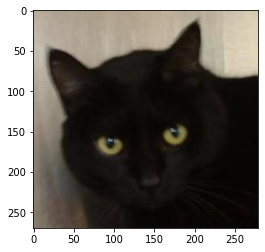

In [2]:
# train data의 상위 경로
train_data_path = '/content/Dogs-vs-cats/train'

import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

file_list = []
for file_path in glob.glob(os.path.join(train_data_path, "*.jpg")):
  file_list.append(file_path)

print(len(file_list))
print(file_list[0])

img = Image.open(file_list[0])
plt.imshow(img)

# Train & Validation 분리 및 데이터 클래스 생성

In [5]:
import os
import glob
import torch
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

class CatDog(Dataset):
  classes={"cat":0, "dog":1}
  invert_classes = ["cat", "dog"]
  def __init__(self, data_root_path, phase="train"):
    self.phase = phase
    self.data_root_path = data_root_path
    self.dataset = self._set_dataset()
    self.mean = [0.4883, 0.4551, 0.4174]
    self.std = [0.2265, 0.2214, 0.2220]
    self.transforms = self.set_transforms(phase)
    
    
  def _set_dataset(self):
    dataset = []
    for file_path in glob.glob(os.path.join(train_data_path, "*.jpg")):
      dataset.append(file_path)
    if self.phase == "test":
      return dataset
    else:
      self.cat_dataset = []
      self.dog_dataset = []
      for file_path in dataset:
        fn = os.path.basename(file_path).split(".")[0]
        if fn == "cat":
          self.cat_dataset.append(file_path)
        elif fn == "dog":
          self.dog_dataset.append(file_path)
      cat_train_x, cat_valid_x = train_test_split(self.cat_dataset, test_size=0.2, random_state=2022, shuffle=True)
      dog_train_x, dog_valid_x = train_test_split(self.dog_dataset, test_size=0.2, random_state=2022, shuffle=True)
      if self.phase == "train":
        return cat_train_x + dog_train_x
      else:
        return cat_valid_x + dog_valid_x
  
  def __str__(self):
    msg = f"==== {self.phase} Dataset ====\n"
    msg += f"  • # of data: {len(self.dataset)}\n"
    if self.phase == "train" or self.phase == "valid":
      msg += f"     - # of cat: {len(self.cat_dataset)}\n"
      msg += f"     - # of dog: {len(self.dog_dataset)}"
    return msg

  def set_transforms(self, phase):
    if phase == "train":
      return T.Compose([T.Resize(512),
                        T.RandomResizedCrop(224), 
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(self.mean, self.std)])
    else:
      return T.Compose([T.Resize(256), 
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(self.mean, self.std)])

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
      file_path = self.dataset[idx]
      image = Image.open(file_path)
      label_name = os.path.basename(file_path).split(".")[0]
      label = torch.tensor(self.classes[label_name], dtype=torch.long)

      new_image = self.transforms(image)

      return new_image, label

In [6]:
train_data_path = '/content/Dogs-vs-cats/train'

train_dataset = CatDog(train_data_path, phase="train")
valid_dataset = CatDog(train_data_path, phase="valid")

print(train_dataset)
print(valid_dataset)


==== train Dataset ====
  • # of data: 20000
     - # of cat: 12500
     - # of dog: 12500
==== valid Dataset ====
  • # of data: 5000
     - # of cat: 12500
     - # of dog: 12500


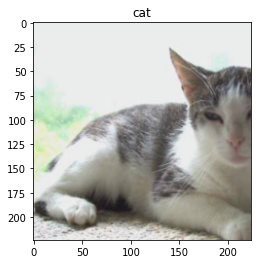

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, title, mean=None, std=None):
  np_img = image.numpy().transpose(1,2,0)
  if not(mean == None or std == None):
    np_img = std * np_img + mean
  np_img = np.clip(np_img, 0, 1)
  plt.imshow(np_img)
  if title is not None:
    plt.title(title)
  plt.pause(0.01)


train_img, train_label = train_dataset[0]

imshow(train_img, title=train_dataset.invert_classes[train_label], mean=train_dataset.mean, std=train_dataset.std)

In [36]:
# setup configuration
import torch
import numpy as np

valid_ratio = 0.1
shuffle = True
random_seed = 0xAB

# fix random seed
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [37]:
# import DataLoader in PyTorch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# create data loaders to feed data into our model
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=SequentialSampler(valid_dataset))

# model fine-tuning

In [38]:
import torch.nn as nn
import torchvision.models as models
# import cuda in PyTorch
import torch.cuda as cuda

# check device for training
device = 'cuda' if cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=True) # call the pre-trained model
in_features = model.fc.in_features

model.fc = nn.Linear(in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss function for classification
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) # stochastic gradient descent with learning rate of 0.0001

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
def train_one_epoch(model, train_loader, criterion, optimizer, **kwargs):
  print_freq = kwargs.pop("print_freq")
  device = kwargs.pop("device")

  model.train() # train mode
  
  for batch_step, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets= targets.to(device) # input and target to device(gpu)

    outputs = model(inputs) # forward pass
    loss = criterion(outputs, targets) # calculate the loss 

    optimizer.zero_grad() # clear gradients
    loss.backward() # backpropagation
    optimizer.step() # update the parameters

    if batch_step % print_freq == 0 and batch_step != 0: # track the training
      loss = loss.item()
      print(f'  [{batch_step:>3d}/{len(train_loader):>3d}]  train loss: {loss:>7f}')

In [40]:
def validation(model, valid_loader, criterion, **kwargs):
  device = kwargs.pop("device")
  valid_loss = 0.0
  valid_correct = 0
  valid_nbatch = len(valid_loader)
  valid_ndata = len(valid_loader.dataset)

  model.eval()

  for batch_step, (inputs, targets) in enumerate(valid_loader):
    with torch.no_grad():
      inputs = inputs.to(device)
      targets= targets.to(device) # input and target to device(gpu)
      outputs = model(inputs)

      valid_loss += criterion(outputs, targets).item() # add up the loss
      valid_correct += (outputs.argmax(1) == targets).type(torch.float).sum().item() # add up the correct predictions

  valid_loss /= valid_nbatch
  valid_accuracy = valid_correct / valid_ndata
  print(f"  valid accuracy: {(100*valid_accuracy):>0.1f}%, valid loss: {valid_loss:>8f}")
  return valid_loss, valid_accuracy

In [41]:
# measure the pre-trained model without training
validation(model, valid_loader, criterion, device=device)

  valid accuracy: 52.4%, valid loss: 0.732757


(0.7327570430934429, 0.5236)

In [42]:
# train the model
epochs = 30
print_freq = 50
valid_preq = 2
best_valid_accuracy = -1

save_path = '/content/drive/MyDrive/ABR Laboratory/ABR::Education/Dogs-vs-cats'
 
print('training starts!')
for epoch in range(epochs):
    print(f'Epoch [{epoch:>3d} / {epochs:3d}]')
    train_one_epoch(model, train_loader, criterion, optimizer, device=device, print_freq=print_freq)
    
    if (epoch !=0 and epoch % valid_preq == 0) or (epoch == epochs):
      valid_loss, valid_accuracy = validation(model, valid_loader, criterion, device=device)
      
      if best_valid_accuracy < valid_accuracy:
        torch.save(model.state_dict(), os.path.join(save_path, "best.pt"))
        best_valid_accuracy = valid_accuracy

torch.save(model.state_dict(), os.path.join(save_path, "checkpoint.pt"))
print('\ntraining is finished!')

training starts!
Epoch [  0 /  30]
  [ 50/157]  train loss: 0.689654
  [100/157]  train loss: 0.599358
  [150/157]  train loss: 0.608336
Epoch [  1 /  30]
  [ 50/157]  train loss: 0.539376
  [100/157]  train loss: 0.496607
  [150/157]  train loss: 0.487211
Epoch [  2 /  30]
  [ 50/157]  train loss: 0.483154
  [100/157]  train loss: 0.457679
  [150/157]  train loss: 0.415748
  valid accuracy: 91.9%, valid loss: 0.368383
Epoch [  3 /  30]
  [ 50/157]  train loss: 0.436436
  [100/157]  train loss: 0.369939
  [150/157]  train loss: 0.436109
Epoch [  4 /  30]
  [ 50/157]  train loss: 0.374216
  [100/157]  train loss: 0.348558
  [150/157]  train loss: 0.355473
  valid accuracy: 95.1%, valid loss: 0.273642
Epoch [  5 /  30]
  [ 50/157]  train loss: 0.359219
  [100/157]  train loss: 0.316804
  [150/157]  train loss: 0.318401
Epoch [  6 /  30]
  [ 50/157]  train loss: 0.364551
  [100/157]  train loss: 0.328051
  [150/157]  train loss: 0.300300
  valid accuracy: 96.0%, valid loss: 0.222775
Epoch

KeyboardInterrupt: ignored

# model training

In [50]:
import torch.nn as nn
import torchvision.models as models
# import cuda in PyTorch
import torch.cuda as cuda

# check device for training
device = 'cuda' if cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=False) # call the pre-trained model
in_features = model.fc.in_features

model.fc = nn.Linear(in_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss function for classification
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # stochastic gradient descent with learning rate of 0.01

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [51]:
# train the model
epochs = 30
print_freq = 50
valid_preq = 2
best_valid_accuracy = -1

save_path = '/content/drive/MyDrive/ABR Laboratory/ABR::Education/Dogs-vs-cats'
 
print('training starts!')
for epoch in range(epochs):
    print(f'Epoch [{epoch:>3d} / {epochs:3d}]')
    train_one_epoch(model, train_loader, criterion, optimizer, device=device, print_freq=print_freq)
    
    if (epoch !=0 and epoch % valid_preq == 0) or (epoch == epochs):
      valid_loss, valid_accuracy = validation(model, valid_loader, criterion, device=device)
      
      if best_valid_accuracy < valid_accuracy:
        torch.save(model.state_dict(), os.path.join(save_path, "best.pt"))
        best_valid_accuracy = valid_accuracy

torch.save(model.state_dict(), os.path.join(save_path, "checkpoint.pt"))
print('\ntraining is finished!')

training starts!
Epoch [  0 /  30]
  [ 50/157]  train loss: 0.659463
  [100/157]  train loss: 0.640668
  [150/157]  train loss: 0.656320
Epoch [  1 /  30]
  [ 50/157]  train loss: 0.589534
  [100/157]  train loss: 0.607620
  [150/157]  train loss: 0.639233
Epoch [  2 /  30]
  [ 50/157]  train loss: 0.572977
  [100/157]  train loss: 0.629746
  [150/157]  train loss: 0.632933
  valid accuracy: 68.3%, valid loss: 0.599531
Epoch [  3 /  30]
  [ 50/157]  train loss: 0.625781
  [100/157]  train loss: 0.628449
  [150/157]  train loss: 0.625283
Epoch [  4 /  30]
  [ 50/157]  train loss: 0.514392
  [100/157]  train loss: 0.572285
  [150/157]  train loss: 0.555404
  valid accuracy: 70.8%, valid loss: 0.565040
Epoch [  5 /  30]
  [ 50/157]  train loss: 0.587879
  [100/157]  train loss: 0.519846
  [150/157]  train loss: 0.581496
Epoch [  6 /  30]
  [ 50/157]  train loss: 0.591747
  [100/157]  train loss: 0.565423
  [150/157]  train loss: 0.528806
  valid accuracy: 75.4%, valid loss: 0.514859
Epoch

KeyboardInterrupt: ignored

# some layer fine-tuning

In [54]:
import torch.nn as nn
import torchvision.models as models
# import cuda in PyTorch
import torch.cuda as cuda

# check device for training
device = 'cuda' if cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=True) # call the pre-trained model
in_features = model.fc.in_features

model.fc = nn.Linear(in_features, 2)

for child in model.children():
  for param in child.parameters():
    param.required_grad = False

model.layer3.requires_grad = True
model.layer4.requires_grad = True
model.avgpool.requires_grad = True
model.fc.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss function for classification
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) # stochastic gradient descent with learning rate of 0.0001

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# train the model
epochs = 30
print_freq = 50
valid_preq = 2
best_valid_accuracy = -1

save_path = '/content/drive/MyDrive/ABR Laboratory/ABR::Education/Dogs-vs-cats'
 
print('training starts!')
for epoch in range(epochs):
    print(f'Epoch [{epoch:>3d} / {epochs:3d}]')
    train_one_epoch(model, train_loader, criterion, optimizer, device=device, print_freq=print_freq)
    
    if (epoch !=0 and epoch % valid_preq == 0) or (epoch == epochs):
      valid_loss, valid_accuracy = validation(model, valid_loader, criterion, device=device)
      
      if best_valid_accuracy < valid_accuracy:
        torch.save(model.state_dict(), os.path.join(save_path, "best.pt"))
        best_valid_accuracy = valid_accuracy

torch.save(model.state_dict(), os.path.join(save_path, "checkpoint.pt"))
print('\ntraining is finished!')

training starts!
Epoch [  0 /  30]
  [ 50/157]  train loss: 0.792198
  [100/157]  train loss: 0.728969
  [150/157]  train loss: 0.698436
Epoch [  1 /  30]
  [ 50/157]  train loss: 0.596626
  [100/157]  train loss: 0.585508
  [150/157]  train loss: 0.508940
Epoch [  2 /  30]
  [ 50/157]  train loss: 0.554864
  [100/157]  train loss: 0.481087
  [150/157]  train loss: 0.504854
  valid accuracy: 87.5%, valid loss: 0.427673
Epoch [  3 /  30]
  [ 50/157]  train loss: 0.465049
  [100/157]  train loss: 0.450276
  [150/157]  train loss: 0.398823
Epoch [  4 /  30]
  [ 50/157]  train loss: 0.404222
  [100/157]  train loss: 0.393951
  [150/157]  train loss: 0.442167
  valid accuracy: 92.7%, valid loss: 0.316201
Epoch [  5 /  30]
  [ 50/157]  train loss: 0.378929
  [100/157]  train loss: 0.325216
  [150/157]  train loss: 0.342126
Epoch [  6 /  30]
  [ 50/157]  train loss: 0.353954
  [100/157]  train loss: 0.320073
  [150/157]  train loss: 0.333751
  valid accuracy: 94.5%, valid loss: 0.254361
Epoch